# APT Activity and Stage Prediction with RL

This notebook implements a Reinforcement Learning (RL) model using `stable-baselines3` PPO to predict the next APT `Activity` and `Stage` from network flow data. It includes data preprocessing, a custom Gymnasium environment, training, and enhanced visualization with confusion matrices and heatmaps.

In [ ]:
# Install required packages (uncomment if running in Colab or a fresh environment)
# !pip install gymnasium pandas numpy sklearn imblearn seaborn matplotlib torch
%pip install stable-baselines3 sb3-contrib --upgrade
%pip install 'shimmy>=0.2.1'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import time
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from sb3_contrib import RecurrentPPO

# Check SB3 version
import stable_baselines3
print(f"Stable-Baselines3 version: {stable_baselines3.__version__}")

RANDOM_SEED = 1000
np.random.seed(RANDOM_SEED)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 300
%matplotlib inline

Stable-Baselines3 version: 2.5.0


## Data Preprocessing

Define functions to preprocess the data.

In [3]:
def preprocess_data(df):
  # Replace spaces and slashes in column names with underscores
  df.columns = df.columns.str.replace(' ', '_').str.replace('/', '_')

  df = df.drop(columns=['Flow_ID', 'Timestamp'], errors='ignore')
  df = df.replace([np.inf, -np.inf], np.nan).dropna()

  rus = RandomUnderSampler(random_state=RANDOM_SEED)
  numerical_cols = df.columns[:-2]
  X_resampled, y_activity_resampled = rus.fit_resample(df[numerical_cols], df['Activity'])
  df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=numerical_cols),
                            pd.DataFrame(y_activity_resampled, columns=['Activity']),
                            df['Stage'].iloc[rus.sample_indices_]], axis=1)

  scaler = StandardScaler()
  df_resampled[numerical_cols] = scaler.fit_transform(df_resampled[numerical_cols])

  return df_resampled, scaler

def create_sequences(data, seq_length=5):
  X, y_activity, y_stage = [], [], []
  numerical_cols = data.columns[:-2]
  for i in range(len(data) - seq_length):
      X.append(data.iloc[i:i+seq_length][numerical_cols].values)
      y_activity.append(data.iloc[i+seq_length]['Activity'])
      y_stage.append(data.iloc[i+seq_length]['Stage'])
  return np.array(X), np.array(y_activity), np.array(y_stage)

## Custom RL Environment

Define the `APTEnv` class with visualization.

In [4]:
class APTEnv(gym.Env):
  def __init__(self, X, y_activity, y_stage, max_activity, num_stages, feature_names=None):
    super(APTEnv, self).__init__()
    self.X = X
    self.y_activity = y_activity
    self.y_stage = y_stage
    self.current_step = 0
    self.max_steps = len(X) - 1
    self.max_activity = max_activity  # Max Activity value
    self.num_stages = num_stages
    self.feature_names = feature_names if feature_names is not None else [f"Feature {i}" for i in range(X.shape[2])]

    self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(X.shape[1], X.shape[2]), dtype=np.float32)
    self.action_space = spaces.MultiDiscrete([max_activity + 1, num_stages])  # Adjusted for full range

    self.pred_activity_history = []
    self.true_activity_history = []
    self.pred_stage_history = []
    self.true_stage_history = []

    self.fig, self.axs = plt.subplots(2, 2, figsize=(12, 8))
    plt.ion()

  def reset(self, seed=None, options=None):
    super().reset(seed=seed)
    self.current_step = 0
    self.pred_activity_history.clear()
    self.true_activity_history.clear()
    self.pred_stage_history.clear()
    self.true_stage_history.clear()
    return self.X[self.current_step], {}

  def step(self, action):
    activity_pred, stage_pred = action
    true_activity = self.y_activity[self.current_step]
    true_stage = self.y_stage[self.current_step]

    # Simplified reward structure
    reward = 0
    reward += 1 if activity_pred == true_activity else -1
    reward += 1 if stage_pred == true_stage else -1

    self.pred_activity_history.append(activity_pred)
    self.true_activity_history.append(true_activity)
    self.pred_stage_history.append(stage_pred)
    self.true_stage_history.append(true_stage)

    self.current_step += 1
    terminated = self.current_step >= self.max_steps
    truncated = False
    obs = self.X[self.current_step] if not terminated else np.zeros_like(self.X[0])
    info = {}

    return obs, reward, terminated, truncated, info

  def render(self):
    for ax in self.axs.flat:
      ax.clear()

    current_state = self.X[self.current_step]
    seq_length = current_state.shape[0]
    for i, feature_idx in enumerate([0, 1]):
      self.axs[0, 0].plot(range(seq_length), current_state[:, feature_idx], label=self.feature_names[feature_idx])
    self.axs[0, 0].set_title(f"State at Step {self.current_step}/{self.max_steps}")
    self.axs[0, 0].set_xlabel("Sequence Step")
    self.axs[0, 0].set_ylabel("Normalized Value")
    self.axs[0, 0].legend()

    activity_pred, stage_pred = self.action_space.sample()
    true_activity = self.y_activity[self.current_step]
    true_stage = self.y_stage[self.current_step]
    reward = (1 if activity_pred == true_activity else -1) + (1 if stage_pred == true_stage else -1)
    self.axs[0, 1].bar(['Pred Act', 'True Act', 'Pred Stage', 'True Stage', 'Reward'],
                      [activity_pred, true_activity, stage_pred, true_stage, reward],
                      color=['blue', 'green', 'blue', 'green', 'red'])
    self.axs[0, 1].set_ylim(-3, 3)
    self.axs[0, 1].set_title("Action and Reward")

    if self.true_activity_history:
      cm_activity = confusion_matrix(self.true_activity_history, self.pred_activity_history)
      sns.heatmap(cm_activity, annot=True, fmt='d', cmap='Blues', ax=self.axs[1, 0],
                  cbar=False, xticklabels=range(self.max_activity + 1), yticklabels=range(self.max_activity + 1))
      self.axs[1, 0].set_title("Activity Confusion Matrix")
      self.axs[1, 0].set_xlabel("Predicted")
      self.axs[1, 0].set_ylabel("True")

    if self.true_stage_history:
      cm_stage = confusion_matrix(self.true_stage_history, self.pred_stage_history)
      sns.heatmap(cm_stage, annot=True, fmt='d', cmap='Greens', ax=self.axs[1, 1],
                  cbar=False, xticklabels=range(self.num_stages), yticklabels=range(self.num_stages))
      self.axs[1, 1].set_title("Stage Confusion Matrix")
      self.axs[1, 1].set_xlabel("Predicted")
      self.axs[1, 1].set_ylabel("True")

    plt.tight_layout()
    plt.pause(0.1)

  def close(self):
    plt.close(self.fig)

## Load and Process Data

In [5]:
# Actual Data
df = pd.read_csv('/content/processed_apt_datasets.csv')

df_processed, scaler = preprocess_data(df)
feature_names = df_processed.columns[:-2].tolist()

seq_length = 5  # Increased for more context
X, y_activity, y_stage = create_sequences(df_processed, seq_length)
max_activity = int(max(y_activity))  # Dynamically set max Activity
num_stages = int(max(y_stage)) + 1  # Dynamically set number of stages

# Debug data distribution
print("Activity values:", np.unique(y_activity, return_counts=True))
print("Stage values:", np.unique(y_stage, return_counts=True))
print("Processed data shape:", df_processed.shape)
df_processed.head()

Activity values: (array([ 2.,  3.,  4.,  5.,  6.,  7.,  8., 10., 11.]), array([1, 2, 2, 2, 2, 2, 2, 2, 2]))
Stage values: (array([1., 2., 3.]), array([ 4, 11,  2]))
Processed data shape: (22, 83)


,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Flow_Duration,Total_Fwd_Packet,Total_Bwd_packets,Total_Length_of_Fwd_Packet,Total_Length_of_Bwd_Packet,...,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Activity,Stage
33423,-0.519539,0.377945,4.558185,-2.792348,4.582576,-0.432109,-0.341933,-0.288334,-0.265436,-0.428613,...,-0.219288,-0.218218,-0.218427,-0.293637,-0.246828,-0.218218,-0.265552,-0.232927,0,0
65434,-0.519539,-0.652548,-0.232636,0.511501,-0.218218,2.990008,1.088730,0.822910,4.493888,0.026701,...,4.582525,4.582576,4.582574,4.167436,0.395035,4.582576,0.854668,0.086067,0,0
13928,1.105559,1.048495,-0.256006,-2.782596,-0.218218,-0.422733,-0.203481,-0.242032,-0.245955,-0.364816,...,-0.219288,-0.218218,-0.218427,-0.293637,-0.246828,-0.218218,-0.265552,-0.232927,1,1
34171,1.105559,0.220912,-0.256006,0.439985,-0.218218,-0.432813,-0.341933,-0.334636,-0.269248,-0.441635,...,-0.219288,-0.218218,-0.218427,-0.293637,-0.246828,-0.218218,-0.265552,-0.232927,1,1
55051,1.105559,0.667042,-0.256006,0.440346,-0.218218,-0.432818,-0.341933,-0.334636,-0.269248,-0.441635,...,-0.219288,-0.218218,-0.218427,-0.293637,-0.246828,-0.218218,-0.265552,-0.232927,2,2


In [6]:
df_processed.columns

Index(['Src_IP', 'Src_Port', 'Dst_IP', 'Dst_Port', 'Protocol', 'Flow_Duration',
       'Total_Fwd_Packet', 'Total_Bwd_packets', 'Total_Length_of_Fwd_Packet',
       'Total_Length_of_Bwd_Packet', 'Fwd_Packet_Length_Max',
       'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean',
       'Fwd_Packet_Length_Std', 'Bwd_Packet_Length_Max',
       'Bwd_Packet_Length_Min', 'Bwd_Packet_Length_Mean',
       'Bwd_Packet_Length_Std', 'Flow_Bytes_s', 'Flow_Packets_s',
       'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min',
       'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max',
       'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean', 'Bwd_IAT_Std',
       'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags',
       'Fwd_URG_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Length',
       'Bwd_Header_Length', 'Fwd_Packets_s', 'Bwd_Packets_s',
       'Packet_Length_Min', 'Packet_Length_Max', 'Packet_Length_Mean',
       'Packet_Length_Std', 'Packet_Length_Variance', 'FIN_Flag

## Train the RL Model

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16       |
|    ep_rew_mean     | -21.5    |
| time/              |          |
|    fps             | 270      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 16          |
|    ep_rew_mean          | -19.2       |
| time/                   |             |
|    fps                  | 144         |
|    iterations           | 2           |
|    time_elapsed         | 28          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.030867765 |
|    clip_fraction        | 0.247       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.85       |
|    explained_variance   | -0.019      |
|    learnin

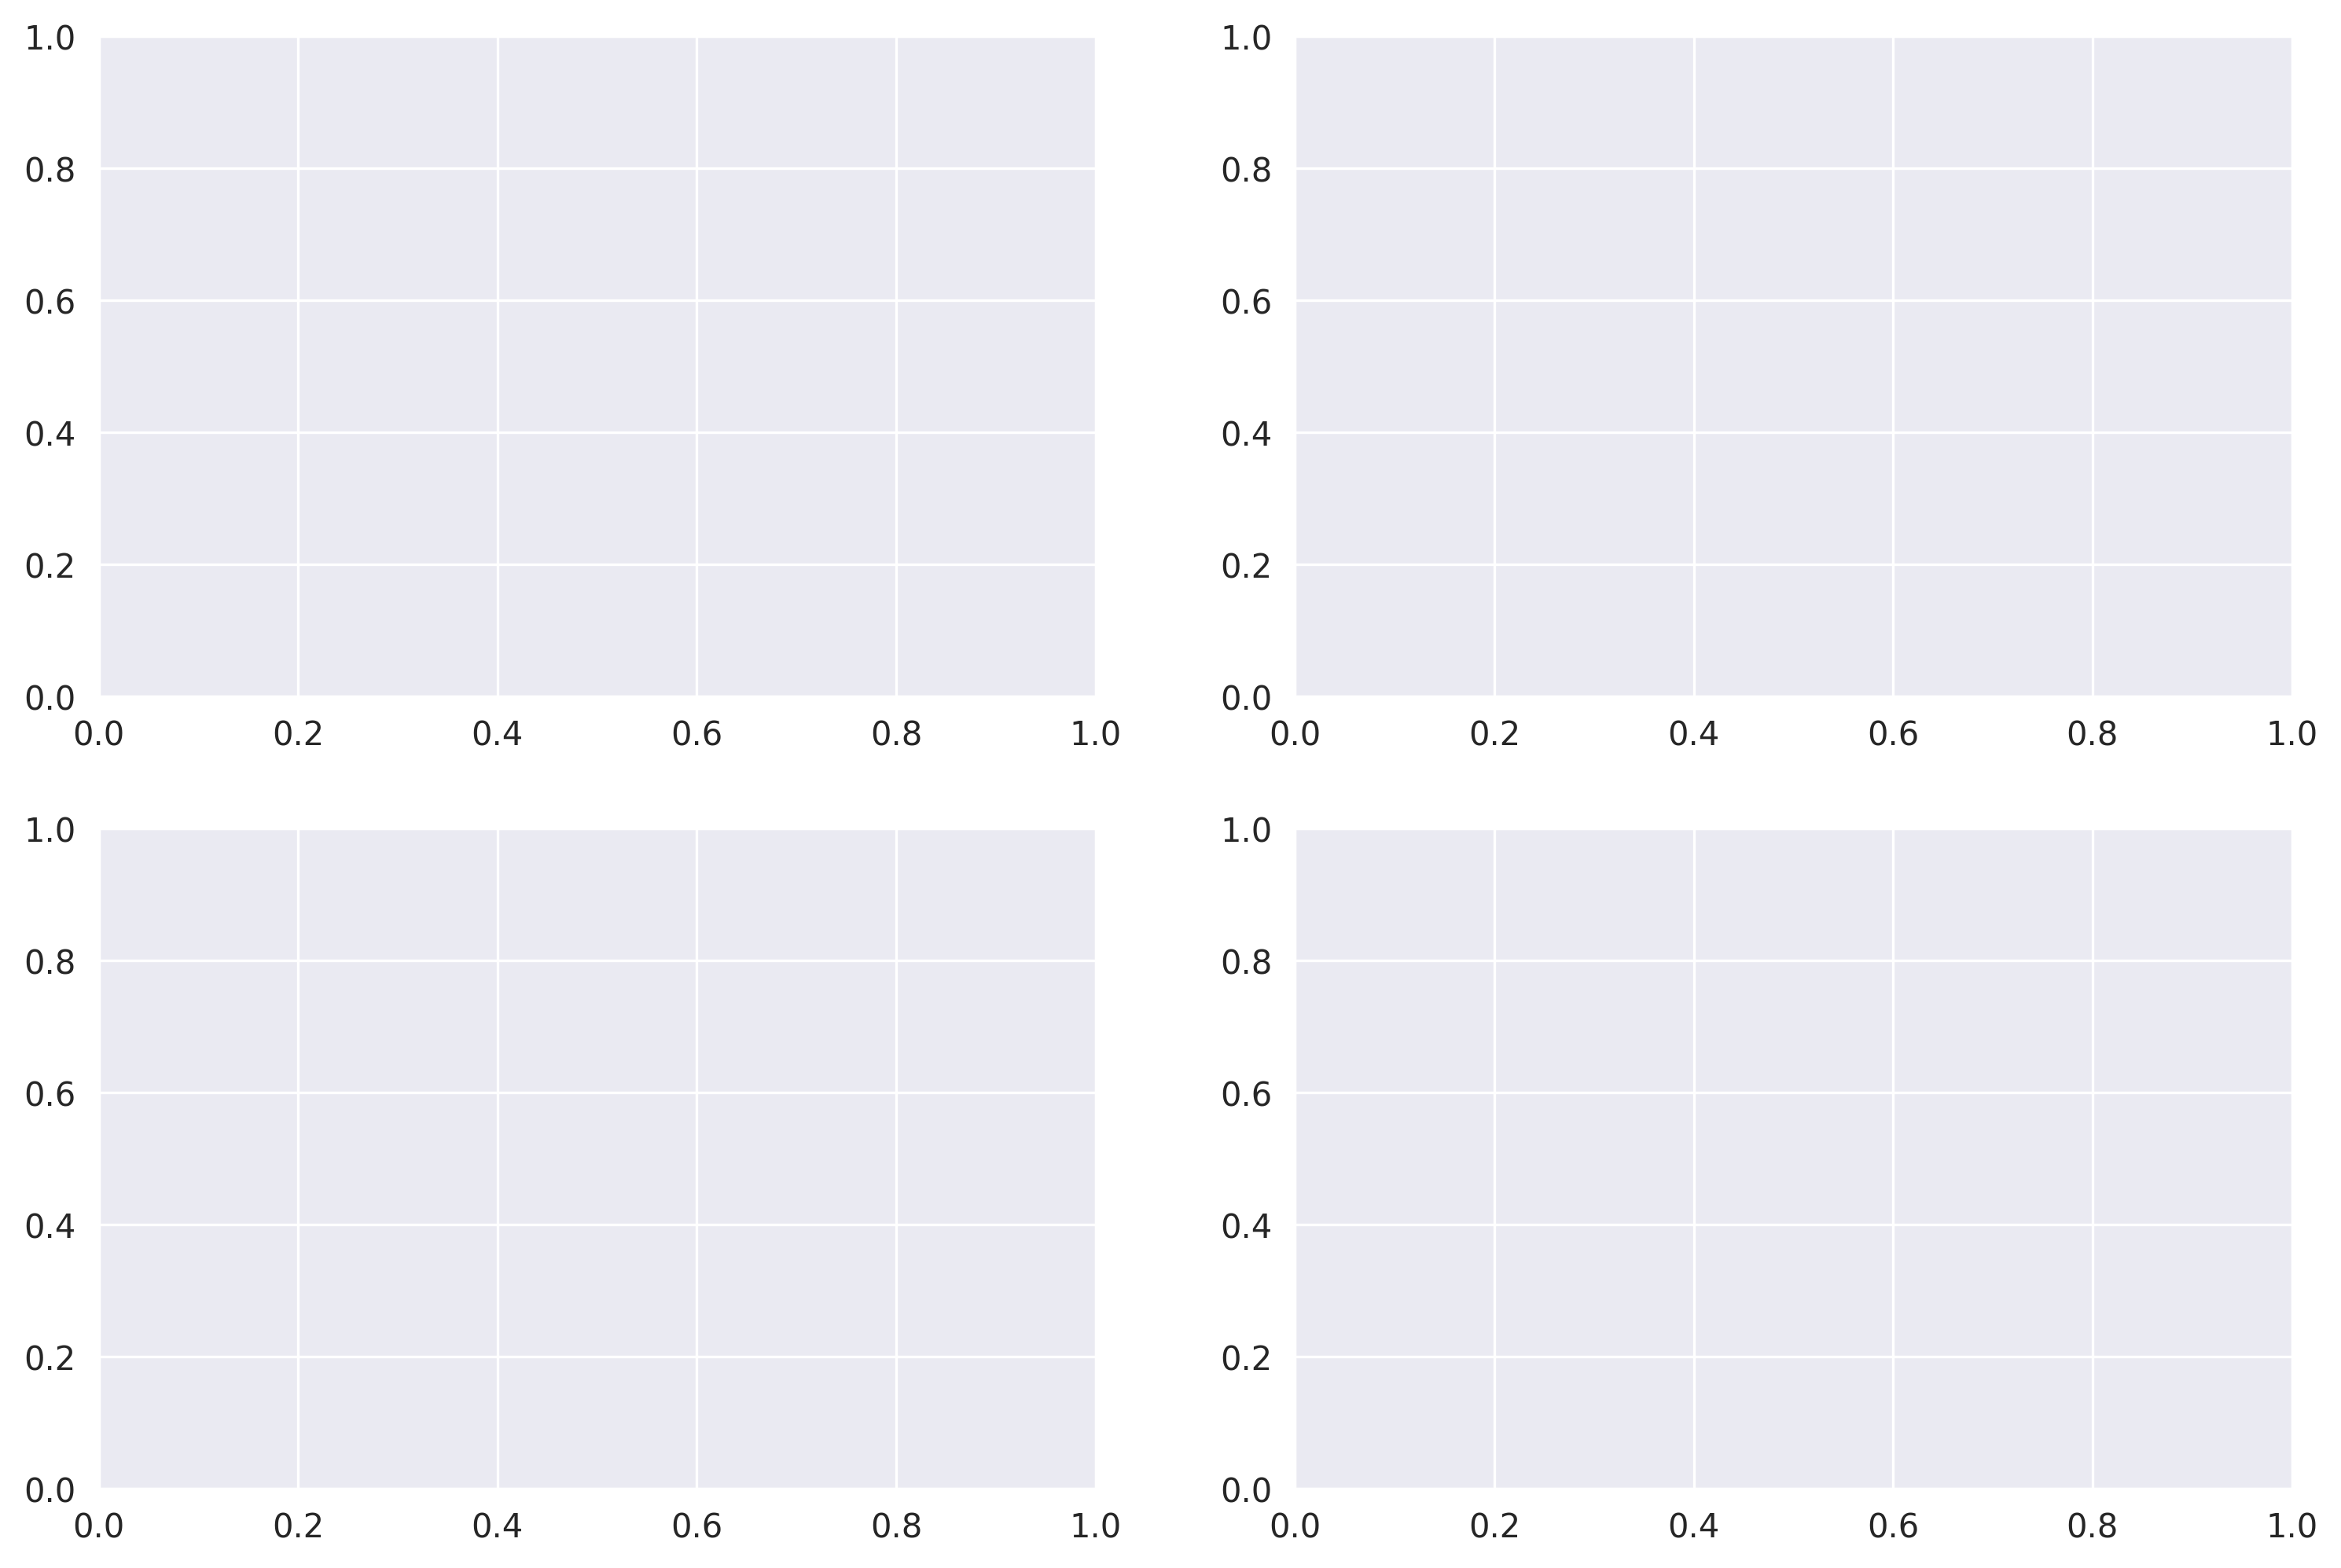

In [ ]:
# Create and vectorize environment with Monitor
env = APTEnv(X, y_activity, y_stage, max_activity, num_stages, feature_names)
env = Monitor(env)
env = DummyVecEnv([lambda: env])
env = VecNormalize(env, norm_obs=True, norm_reward=False)

model = RecurrentPPO(
  policy="MlpLstmPolicy",
  env=env,
  verbose=1,
  n_steps=2048,
  batch_size=64,
  n_epochs=10,
  learning_rate=0.0003,  # Increased learning rate
  policy_kwargs={
    'lstm_hidden_size': 128,  # Increased LSTM size
    'net_arch': dict(pi=[128, 128], vf=[128, 128])  # Deeper network
  }
)

start_time = time.time()
model.learn(total_timesteps=50000)  # Increased timesteps
print(f"Training time: {time.time() - start_time:.2f} seconds")

model.save("ppo_apt_predictor")
with open("scaler.pkl", "wb") as f:
  pickle.dump(scaler, f)

## Evaluate the Model

Mean reward: 32.00, Std reward: 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>


Activity Classification Report:
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00         1
         3.0       1.00      1.00      1.00         2
         4.0       0.67      1.00      0.80         2
         5.0       1.00      1.00      1.00         2
         6.0       1.00      1.00      1.00         2
         7.0       1.00      1.00      1.00         2
         8.0       1.00      0.50      0.67         2
        10.0       1.00      1.00      1.00         2
        11.0       1.00      1.00      1.00         1

    accuracy                           0.94        16
   macro avg       0.96      0.94      0.94        16
weighted avg       0.96      0.94      0.93        16


Stage Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         4
         2.0       1.00      1.00      1.00        10
         3.0       1.00      1.00      1.00         2

    accuracy  

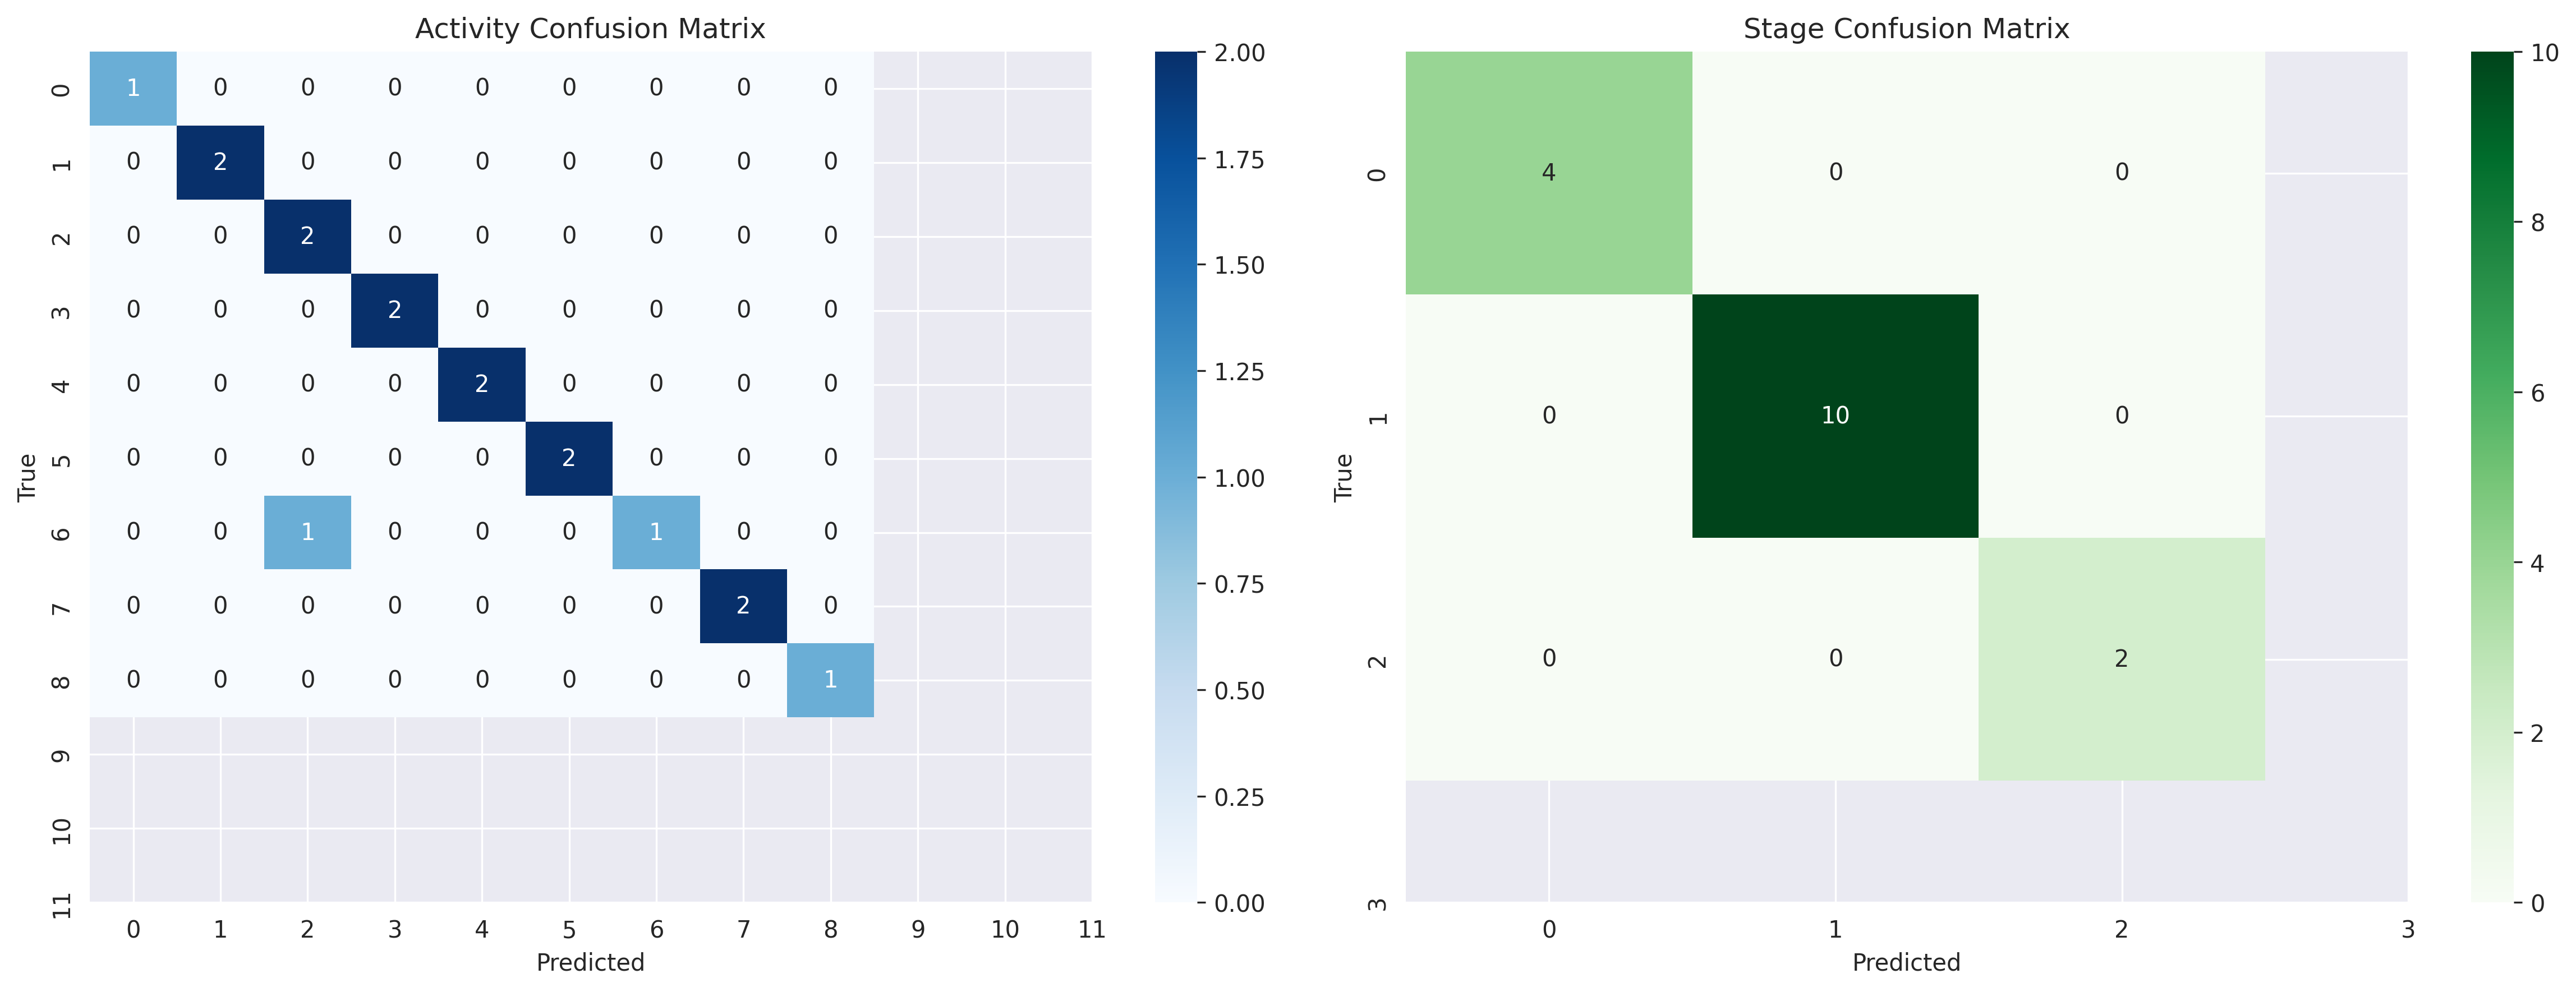

In [8]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f}, Std reward: {std_reward:.2f}")

predictions = []
obs = env.reset()
lstm_states = None
episode_starts = np.ones((env.num_envs,), dtype=bool)

# Access the underlying APTEnv environment to get max_steps
max_steps = env.envs[0].unwrapped.max_steps

for _ in range(max_steps):
  action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts)
  obs, reward, done, info = env.step(action)
  predictions.append(action)
  env.envs[0].render()
  episode_starts = done
  if done.any():
    break

y_pred_activity = [p[0][0] for p in predictions]
y_pred_stage = [p[0][1] for p in predictions]
y_true_activity = y_activity[:-1]  # Align with predictions
y_true_stage = y_stage[:-1]

print("\nActivity Classification Report:")
print(classification_report(y_true_activity, y_pred_activity, zero_division=0))
print("\nStage Classification Report:")
print(classification_report(y_true_stage, y_pred_stage, zero_division=0))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
cm_activity = confusion_matrix(y_true_activity, y_pred_activity)
sns.heatmap(cm_activity, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=range(max_activity + 1), yticklabels=range(max_activity + 1))
ax1.set_title("Activity Confusion Matrix")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")

cm_stage = confusion_matrix(y_true_stage, y_pred_stage)
sns.heatmap(cm_stage, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=range(num_stages), yticklabels=range(num_stages))
ax2.set_title("Stage Confusion Matrix")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True")

plt.tight_layout()
plt.show()

env.envs[0].close()